In [ ]:
%pip install cobra matplotlib pandas

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import cobra
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

### Load E.coli Model


In [ ]:
# Load the E. coli Model
from cobra import io
e_coli_model = io.load_model("e_coli_core")

Output()

In [ ]:
e_coli_model

Name,e_coli_core
Memory address,7de673973be0
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [ ]:
# View model summary
print(e_coli_model.summary())

Objective
1.0 BIOMASS_Ecoli_core_w_GAM = 0.8739215069684295

Uptake
------
Metabolite    Reaction  Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e    10         6 100.00%
     nh4_e    EX_nh4_e 4.765         0   0.00%
      o2_e     EX_o2_e  21.8         0   0.00%
      pi_e     EX_pi_e 3.215         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -22.81         1 100.00%
     h2o_e EX_h2o_e -29.18         0   0.00%
       h_e   EX_h_e -17.53         0   0.00%



In [ ]:
# Basic model properties
print("Number of reactions: ", len(e_coli_model.reactions))
print("Number of metabolites: ", len(e_coli_model.metabolites))
print("Number of genes: ", len(e_coli_model.genes))

Number of reactions:  95
Number of metabolites:  72
Number of genes:  137


In [ ]:
print('Complete model: ', e_coli_model.optimize())

Complete model:  <Solution 0.874 at 0x7de672acfd60>


### 2. Single-Gene Knockouts

In [ ]:
# Conduct single gene deletion
deletion_results = single_gene_deletion(e_coli_model)
deletion_results

,ids,growth,status
0,{b2914},8.739215e-01,optimal
1,{b0451},8.739215e-01,optimal
2,{b1818},8.739215e-01,optimal
3,{b3236},8.258193e-01,optimal
4,{b2133},8.739215e-01,optimal
...,...,...,...
132,{b3870},8.739215e-01,optimal
133,{b2587},8.739215e-01,optimal
134,{b2464},8.739215e-01,optimal
135,{b2926},9.561137e-16,optimal


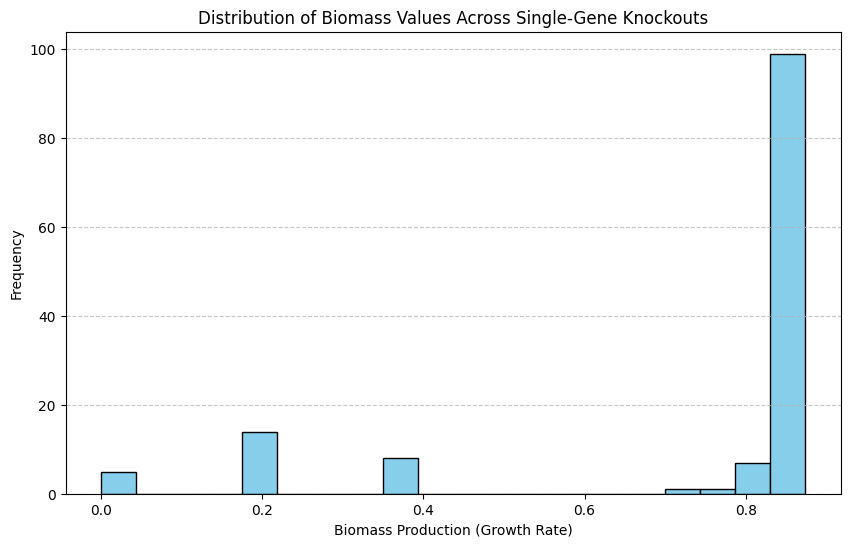

In [ ]:
# Visualize distribution of biomass values across single-gene knock-outs
plt.figure(figsize=(10, 6))
plt.hist(deletion_results['growth'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Biomass Values Across Single-Gene Knockouts")
plt.xlabel("Biomass Production (Growth Rate)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Get essential genes
essentail_genes = deletion_results[deletion_results['growth'] <= 0] # To obtain the genes where biomass approaches zero
essentail_genes

,ids,growth,status
40,{b0720},-8.871332e-15,optimal
96,{b1136},-1.405299e-15,optimal


## Involved Metabolic Reactions

In [ ]:
# Get gene name
e_coli_model.genes.get_by_id("b1136")

Gene identifier,b1136
Name,icd
Memory address,0x79be71f106d0
Functional,True
In 1 reaction(s),ICDHyr


In [ ]:
e_coli_model.genes.get_by_id("b0720")

Gene identifier,b0720
Name,gltA
Memory address,0x79be742face0
Functional,True
In 1 reaction(s),CS


In [ ]:
# Get reaction name
e_coli_model.reactions.get_by_id("ICDHyr")

Reaction identifier,ICDHyr
Name,Isocitrate dehydrogenase (NADP)
Memory address,0x7de672d723e0
Stoichiometry,icit_c + nadp_c <=> akg_c + co2_c + nadph_c Isocitrate + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + CO2 CO2 + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,b1136
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
e_coli_model.reactions.get_by_id("CS")

Reaction identifier,CS
Name,Citrate synthase
Memory address,0x79be74433c70
Stoichiometry,accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c Acetyl-CoA + H2O H2O + Oxaloacetate --> Citrate + Coenzyme A + H+
GPR,b0720
Lower bound,0.0
Upper bound,1000.0


### 3. Synthetic Lethality (Double-Gene Knockouts)

In [ ]:
# Recall essential genes
essentail_genes

,ids,growth,status
40,{b0720},-8.871332e-15,optimal
96,{b1136},-1.405299e-15,optimal


In [ ]:
# Get essential genes' IDs as strings
essential_genes_ids = [list(gene_set)[0] for gene_set in essentail_genes['ids']]  # Convert sets to strings
essential_genes_ids

['b0720', 'b1136']

In [ ]:
# Identify non-essential genes
non_essential_genes = [gene.id for gene in e_coli_model.genes if gene.id not in essential_genes_ids]
len(non_essential_genes)

135

In [ ]:
# Generate all non-essential gene pairs
gene_pairs = list(combinations(non_essential_genes, 2))

In [ ]:
# Perform double-gene deletions for each pair
results = []
for pair in tqdm(gene_pairs, desc="Testing gene pairs for synthetic lethality"):
    deletion_result = double_gene_deletion(e_coli_model, pair) # Perform double-gene knockout
    growth = deletion_result['growth'][0]

    if growth <= 0: # Check for synthetic lethality (growth == 0)
        results.append({
            "Gene 1": pair[0],
            "Gene 2": pair[1],
            "Biomass": growth
        })

Testing gene pairs for synthetic lethality: 100%|██████████| 9045/9045 [00:26<00:00, 346.69it/s]


In [ ]:
# Summarize the results in a DataFrame
synthetic_lethality_table = pd.DataFrame(results)
synthetic_lethality_table

,Gene 1,Gene 2,Biomass
0,b1849,b2926,-1.884693e-17
1,b1276,b2926,-1.884693e-17
2,b0118,b2926,-1.884693e-17
3,b0726,b2779,-4.879718e-16
4,b0726,b1779,-3.613008e-16
...,...,...,...
87,b0903,b2926,-1.884693e-17
88,b2926,b0724,-3.766222e-17
89,b2926,b0729,-3.766222e-17
90,b3956,b0721,-2.723911e-15


In [ ]:
# Add gene names to the synthetic lethality table
gene_names = []
for index, row in synthetic_lethality_table.iterrows():
    gene_1_name = e_coli_model.genes.get_by_id(row["Gene 1"]).name # Get the names of Gene 1 and Gene 2
    gene_2_name = e_coli_model.genes.get_by_id(row["Gene 2"]).name

    gene_names.append((gene_1_name, gene_2_name)) # Append the names as a tuple

In [ ]:
# Unpack the gene names into two separate columns
synthetic_lethality_table["Gene 1 Name"] = [name[0] for name in gene_names]
synthetic_lethality_table["Gene 2 Name"] = [name[1] for name in gene_names]

In [ ]:
synthetic_lethality_table

,Gene 1,Gene 2,Biomass,Gene 1 Name,Gene 2 Name
0,b1849,b2926,-1.884693e-17,purT,pgk
1,b1276,b2926,-1.884693e-17,acnA,pgk
2,b0118,b2926,-1.884693e-17,acnB,pgk
3,b0726,b2779,-4.879718e-16,sucA,eno
4,b0726,b1779,-3.613008e-16,sucA,gapA
...,...,...,...,...,...
87,b0903,b2926,-1.884693e-17,pflB,pgk
88,b2926,b0724,-3.766222e-17,pgk,sdhB
89,b2926,b0729,-3.766222e-17,pgk,sucD
90,b3956,b0721,-2.723911e-15,ppc,sdhC
